# Predicting Heart Attack Risk Using Sleep, Work, and Health Habits in Married Adults



In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance


In [3]:
df = pd.read_csv("nhis_2022.csv")  

df = df[df["MARSTCUR"] == 1]

df = df[
    (df["HRSLEEP"].between(1, 24)) &
    (df["HOURSWRK"].between(1, 95)) &
    (df["AGE"].between(18, 85)) &
    (df["SEX"].isin([1, 2])) &
    (df["BMICALC"].between(12.0, 50.0)) &
    (df["MOD10DMIN"].between(1, 995)) &
    (df["VIG10DMIN"].between(1, 995)) &
    (df["HEARTATTEV"].isin([1, 2]))
]

df = df[df["HEARTATTEV"].isin([1, 2])]
df["HEARTATTEV"] = df["HEARTATTEV"].map({1: 0, 2: 1})
df["SEX"] = df["SEX"].map({1: 0, 2: 1})

def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25.0:
        return "Normal"
    elif 25.0 <= bmi < 30.0:
        return "Overweight"
    else:
        return "Obese"

df["BMI_CAT"] = df["BMICALC"].apply(categorize_bmi)

df = pd.get_dummies(df, columns=["BMI_CAT"], prefix="BMI", drop_first=True)

base_features = ["HRSLEEP", "HOURSWRK", "AGE", "SEX", "MOD10DMIN", "VIG10DMIN"]
bmi_dummies = [col for col in df.columns if col.startswith("BMI_")]
features = base_features + bmi_dummies

df = df[features + ["HEARTATTEV"]]

X = df[features]
y = df["HEARTATTEV"]

df = df.reset_index(drop=True)

print("Final dataset shape:", df.shape)
print("Feature matrix shape:", X.shape)
print("Heart attack cases (label=1):", y.sum())

Final dataset shape: (2848, 10)
Feature matrix shape: (2848, 9)
Heart attack cases (label=1): 25


 Class distribution in y_train:
HEARTATTEV
0    2258
1      20
Name: count, dtype: int64
Train shape: (2278, 9)
 Test shape: (570, 9)

 Classification Report (Linear SVM):
              precision    recall  f1-score   support

           0      0.997     0.676     0.806       565
           1      0.021     0.800     0.042         5

    accuracy                          0.677       570
   macro avg      0.509     0.738     0.424       570
weighted avg      0.989     0.677     0.799       570



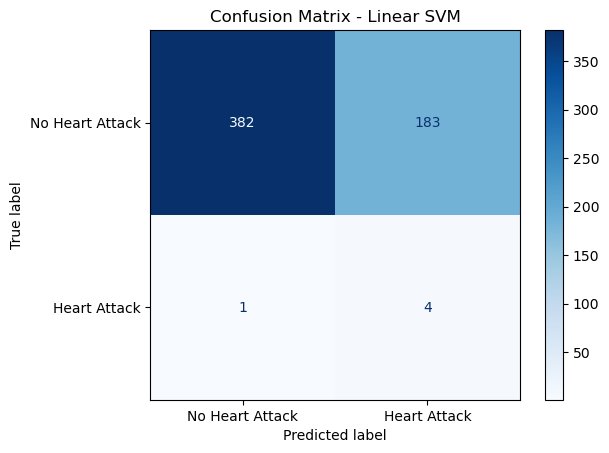

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Stratify because of class imbalance
)

print(" Class distribution in y_train:")
print(y_train.value_counts())

print("Train shape:", X_train.shape)
print(" Test shape:", X_test.shape)

svm_linear = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', C=0.01, class_weight='balanced', random_state=42) 
)

svm_linear.fit(X_train, y_train)

y_pred = svm_linear.predict(X_test)

print("\n Classification Report (Linear SVM):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Attack", "Heart Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Linear SVM")
plt.show()


 Classification Report (RBF SVM):
              precision    recall  f1-score   support

           0      0.998     0.722     0.838       565
           1      0.025     0.800     0.048         5

    accuracy                          0.723       570
   macro avg      0.511     0.761     0.443       570
weighted avg      0.989     0.723     0.831       570



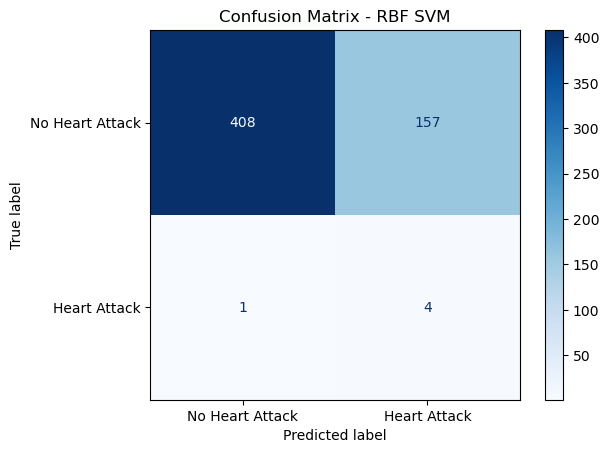

In [5]:
svm_rbf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma=0.01, class_weight='balanced', random_state=42)  
)


svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)

print(" Classification Report (RBF SVM):")
print(classification_report(y_test, y_pred_rbf, digits=3))

cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Attack", "Heart Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - RBF SVM")
plt.show()

 Classification Report (Polynomial SVM):
              precision    recall  f1-score   support

           0      0.994     0.848     0.915       565
           1      0.023     0.400     0.043         5

    accuracy                          0.844       570
   macro avg      0.508     0.624     0.479       570
weighted avg      0.985     0.844     0.907       570



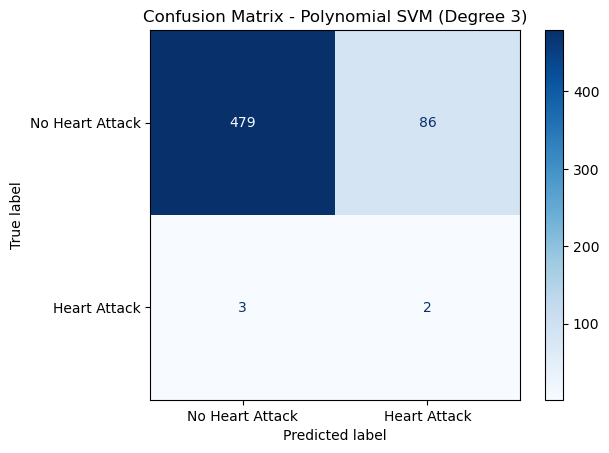

In [6]:
svm_poly = make_pipeline(
    StandardScaler(),
    SVC(kernel='poly', C=1.0, degree=3, class_weight='balanced', random_state=42)  
)

svm_poly.fit(X_train, y_train)

y_pred_poly = svm_poly.predict(X_test)

print(" Classification Report (Polynomial SVM):")
print(classification_report(y_test, y_pred_poly, digits=3))

cm = confusion_matrix(y_test, y_pred_poly)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Heart Attack", "Heart Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Polynomial SVM (Degree 3)")
plt.show()

Best Linear SVM Params: {'svc__C': 100}
Best Accuracy (train, cross-validated): 0.7194775400038559


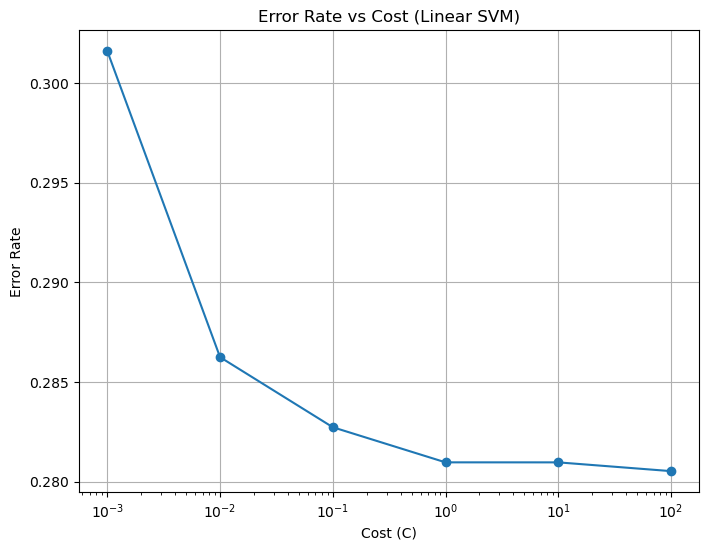

In [29]:
pipe_linear = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', class_weight='balanced', random_state=42)
)

param_grid_linear = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_linear = GridSearchCV(
    pipe_linear, 
    param_grid_linear, 
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1
)

grid_linear.fit(X_train, y_train)

print("Best Linear SVM Params:", grid_linear.best_params_)
print("Best Accuracy (train, cross-validated):", grid_linear.best_score_)


cv_results_linear = pd.DataFrame(grid_linear.cv_results_)

cv_results_linear["error_rate"] = 1 - cv_results_linear["mean_test_score"]

plt.figure(figsize=(8,6))
plt.plot(cv_results_linear['param_svc__C'], cv_results_linear['error_rate'], marker='o')

plt.xscale('log')  
plt.xlabel('Cost (C)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Cost (Linear SVM)')
plt.grid(True)
plt.show()

Best RBF SVM Params: {'svc__C': 0.1, 'svc__gamma': 10}
Best Accuracy (train, cross-validated): 0.9885849238480817


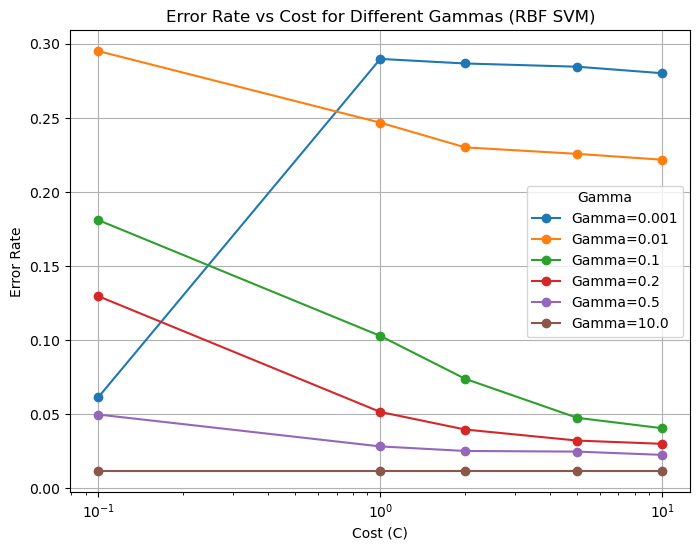

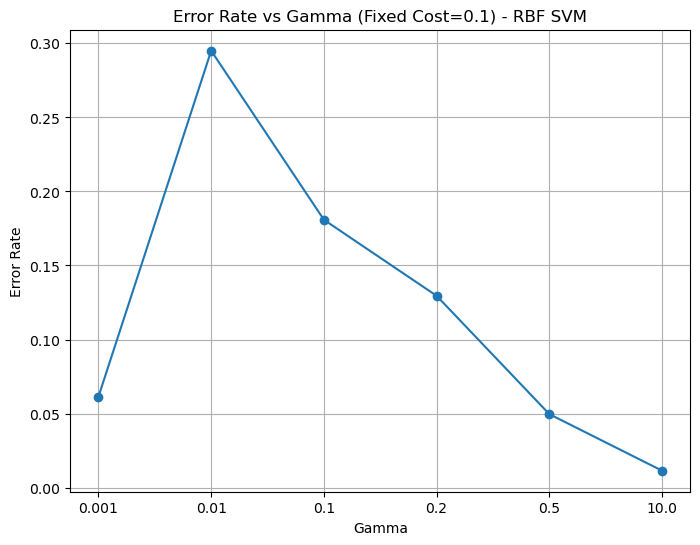

In [21]:
pipe_rbf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', class_weight='balanced', random_state=42)
)

param_grid_rbf = {
    'svc__C': [0.1, 1, 2,5,10],
    'svc__gamma': [0.001, 0.01, 0.1, 0.2, 0.5, 10]
}

grid_rbf = GridSearchCV(
    pipe_rbf, 
    param_grid_rbf, 
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1
)

grid_rbf.fit(X_train, y_train)

print("Best RBF SVM Params:", grid_rbf.best_params_)
print("Best Accuracy (train, cross-validated):", grid_rbf.best_score_)



cv_results_rbf = pd.DataFrame(grid_rbf.cv_results_)

cv_results_rbf["error_rate"] = 1 - cv_results_rbf["mean_test_score"]

gamma_vals = cv_results_rbf['param_svc__gamma'].unique()

numeric_gammas = [g for g in gamma_vals if isinstance(g, (float, np.float64, int))]
string_gammas = [g for g in gamma_vals if isinstance(g, str)]

plt.figure(figsize=(8,6))

for gamma_val in sorted(numeric_gammas):
    subset = cv_results_rbf[cv_results_rbf['param_svc__gamma'] == gamma_val]
    plt.plot(subset['param_svc__C'], subset['error_rate'], marker='o', label=f'Gamma={gamma_val}')

for gamma_val in string_gammas:
    subset = cv_results_rbf[cv_results_rbf['param_svc__gamma'] == gamma_val]
    plt.plot(subset['param_svc__C'], subset['error_rate'], marker='x', linestyle='--', label=f'Gamma={gamma_val}')

plt.xscale('log')  
plt.xlabel('Cost (C)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Cost for Different Gammas (RBF SVM)')
plt.legend(title='Gamma')
plt.grid(True)
plt.show()

best_C_rbf = grid_rbf.best_params_['svc__C']

subset_C_rbf = cv_results_rbf[cv_results_rbf['param_svc__C'] == best_C_rbf]

plt.figure(figsize=(8,6))
plt.plot(subset_C_rbf['param_svc__gamma'].astype(str), subset_C_rbf['error_rate'], marker='o')
plt.xlabel('Gamma')
plt.ylabel('Error Rate')
plt.title(f'Error Rate vs Gamma (Fixed Cost={best_C_rbf}) - RBF SVM')
plt.grid(True)
plt.show()

Best Poly SVM Params: {'svc__C': 100, 'svc__degree': 4}
Best Accuracy (train, cross-validated): 0.9622411798727588


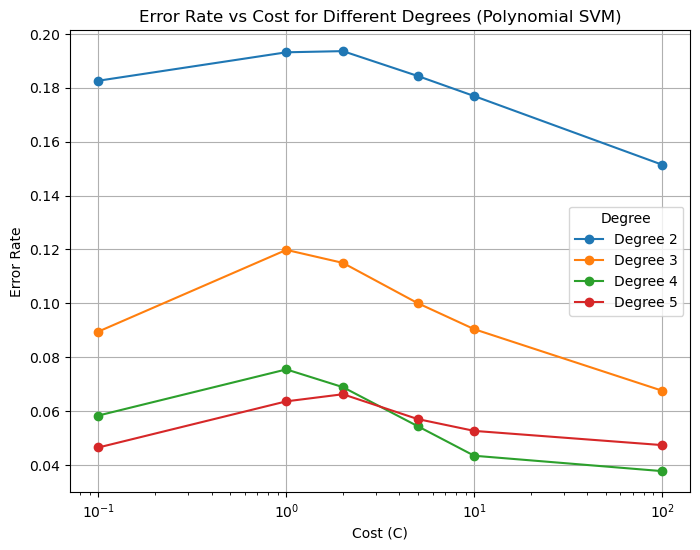

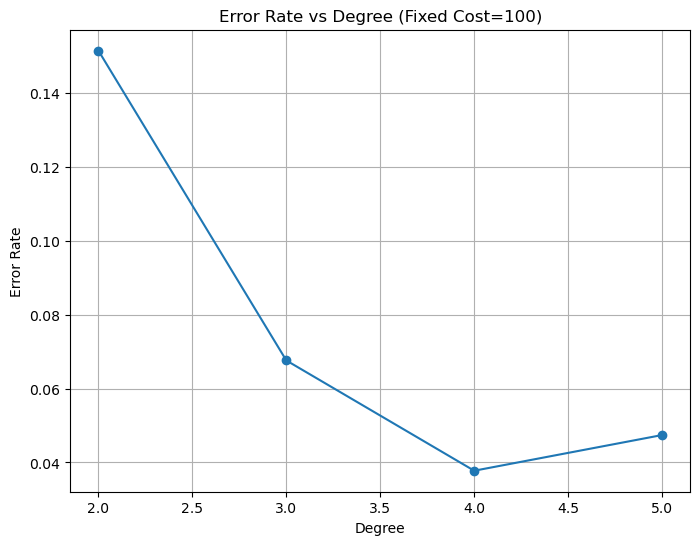

In [20]:
pipe_poly = make_pipeline(
    StandardScaler(),
    SVC(kernel='poly', class_weight='balanced', random_state=42)
)

param_grid_poly = {
    'svc__C': [0.1, 1, 2, 5, 10, 100],
    'svc__degree': [2, 3, 4,5]
}

grid_poly = GridSearchCV(
    pipe_poly, 
    param_grid_poly, 
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1
)

grid_poly.fit(X_train, y_train)

print("Best Poly SVM Params:", grid_poly.best_params_)
print("Best Accuracy (train, cross-validated):", grid_poly.best_score_)


cv_results_poly = pd.DataFrame(grid_poly.cv_results_)

cv_results_poly["error_rate"] = 1 - cv_results_poly["mean_test_score"]

plt.figure(figsize=(8,6))
for deg in sorted(cv_results_poly['param_svc__degree'].unique()):
    subset = cv_results_poly[cv_results_poly['param_svc__degree'] == deg]
    plt.plot(subset['param_svc__C'], subset['error_rate'], marker='o', label=f'Degree {deg}')

plt.xscale('log')  
plt.xlabel('Cost (C)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Cost for Different Degrees (Polynomial SVM)')
plt.legend(title='Degree')
plt.grid(True)
plt.show()

best_C = grid_poly.best_params_['svc__C']

subset_C = cv_results_poly[cv_results_poly['param_svc__C'] == best_C]

plt.figure(figsize=(8,6))
plt.plot(subset_C['param_svc__degree'], subset_C['error_rate'], marker='o')
plt.xlabel('Degree')
plt.ylabel('Error Rate')
plt.title(f'Error Rate vs Degree (Fixed Cost={best_C})')
plt.grid(True)
plt.show()

 Best Linear SVM Results:
Accuracy: 0.6947368421052632
              precision    recall  f1-score   support

           0      0.997     0.694     0.818       565
           1      0.023     0.800     0.044         5

    accuracy                          0.695       570
   macro avg      0.510     0.747     0.431       570
weighted avg      0.989     0.695     0.812       570



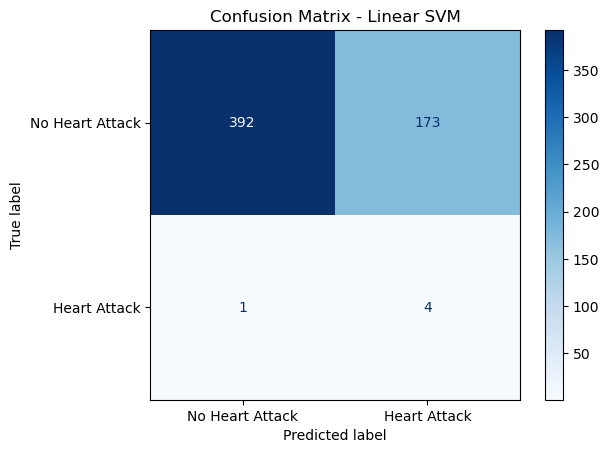


 Best RBF SVM Results:
Accuracy: 0.9894736842105263
              precision    recall  f1-score   support

           0      0.991     0.998     0.995       565
           1      0.000     0.000     0.000         5

    accuracy                          0.989       570
   macro avg      0.496     0.499     0.497       570
weighted avg      0.983     0.989     0.986       570



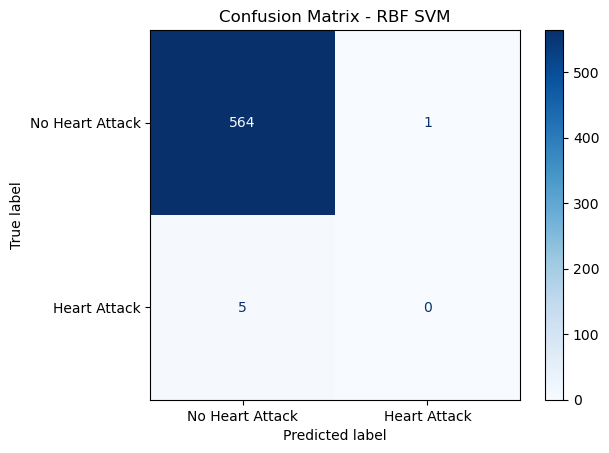


 Best Polynomial SVM Results:
Accuracy: 0.968421052631579
              precision    recall  f1-score   support

           0      0.991     0.977     0.984       565
           1      0.000     0.000     0.000         5

    accuracy                          0.968       570
   macro avg      0.496     0.488     0.492       570
weighted avg      0.982     0.968     0.975       570



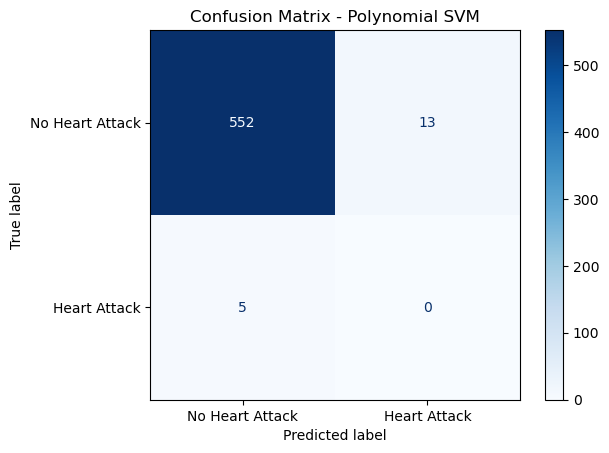

In [13]:
print(" Best Linear SVM Results:")
y_pred_linear = grid_linear.predict(X_test)
acc_linear = accuracy_score(y_test, y_pred_linear)  
print("Accuracy:", acc_linear)
print(classification_report(y_test, y_pred_linear, digits=3))

cm_linear = confusion_matrix(y_test, y_pred_linear)
disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear, display_labels=["No Heart Attack", "Heart Attack"])
disp_linear.plot(cmap="Blues")
plt.title("Confusion Matrix - Linear SVM")
plt.show()

print("\n Best RBF SVM Results:")
y_pred_rbf = grid_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)  
print("Accuracy:", acc_rbf)
print(classification_report(y_test, y_pred_rbf, digits=3))

cm_rbf = confusion_matrix(y_test, y_pred_rbf)
disp_rbf = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=["No Heart Attack", "Heart Attack"])
disp_rbf.plot(cmap="Blues")
plt.title("Confusion Matrix - RBF SVM")
plt.show()

print("\n Best Polynomial SVM Results:")
y_pred_poly = grid_poly.predict(X_test)
acc_poly = accuracy_score(y_test, y_pred_poly)  
print("Accuracy:", acc_poly)
print(classification_report(y_test, y_pred_poly, digits=3))

cm_poly = confusion_matrix(y_test, y_pred_poly)
disp_poly = ConfusionMatrixDisplay(confusion_matrix=cm_poly, display_labels=["No Heart Attack", "Heart Attack"])
disp_poly.plot(cmap="Blues")
plt.title("Confusion Matrix - Polynomial SVM")
plt.show()

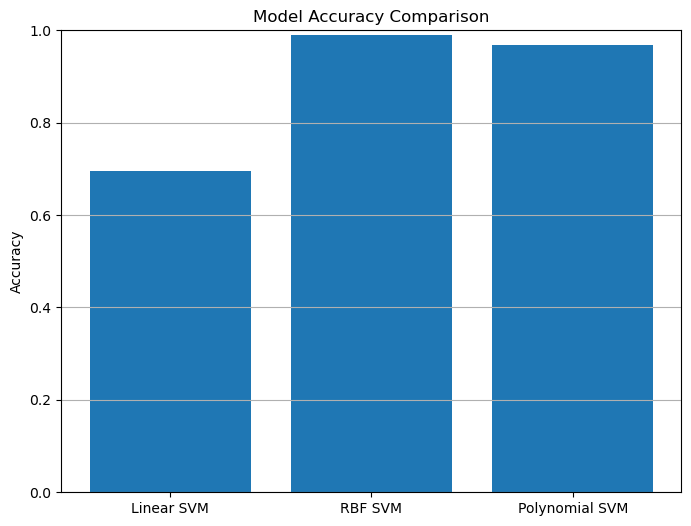

In [19]:
models = ['Linear SVM', 'RBF SVM', 'Polynomial SVM']

accuracies = [acc_linear, acc_rbf, acc_poly]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)

plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')
plt.show()

In [16]:
best_linear_model = grid_linear.best_estimator_.named_steps['svc']

coef = best_linear_model.coef_[0]

feature_importance_linear = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(coef)  
}).sort_values(by='Importance', ascending=False)

print("\n Top Important Features (Linear SVM):")
print(feature_importance_linear)


 Top Important Features (Linear SVM):
           Feature  Importance
2              AGE    1.200444
3              SEX    0.461664
0          HRSLEEP    0.398381
7   BMI_Overweight    0.113388
1         HOURSWRK    0.102074
8  BMI_Underweight    0.101081
5        VIG10DMIN    0.094611
6        BMI_Obese    0.037341
4        MOD10DMIN    0.005199


In [31]:
pipe_rbf_best = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf', 
        C=grid_rbf.best_params_['svc__C'], 
        gamma=grid_rbf.best_params_['svc__gamma'], 
        class_weight='balanced',
        random_state=42
    )
)

pipe_rbf_best.fit(X_train, y_train)

result_rbf = permutation_importance(
    pipe_rbf_best, 
    X_test, 
    y_test, 
    n_repeats=30, 
    random_state=42, 
    n_jobs=-1
)

importance_rbf = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result_rbf.importances_mean
}).sort_values(by='Importance', ascending=False)

display(importance_rbf)

,Feature,Importance
7,BMI_Overweight,0.002456
3,SEX,0.000702
0,HRSLEEP,0.000585
2,AGE,0.000175
1,HOURSWRK,0.000000
4,MOD10DMIN,0.000000
8,BMI_Underweight,0.000000
5,VIG10DMIN,-0.000526
6,BMI_Obese,-0.000585


In [32]:
pipe_poly_best = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='poly', 
        C=grid_poly.best_params_['svc__C'], 
        degree=grid_poly.best_params_['svc__degree'],
        class_weight='balanced',
        random_state=42
    )
)

pipe_poly_best.fit(X_train, y_train)


result_poly = permutation_importance(
    pipe_poly_best, 
    X_test, 
    y_test, 
    n_repeats=30, 
    random_state=42, 
    n_jobs=-1
)

importance_poly = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result_poly.importances_mean
}).sort_values(by='Importance', ascending=False)

display(importance_poly)

,Feature,Importance
7,BMI_Overweight,0.030936
6,BMI_Obese,0.025439
1,HOURSWRK,0.013041
2,AGE,0.007251
3,SEX,0.005497
0,HRSLEEP,0.002281
4,MOD10DMIN,0.000994
8,BMI_Underweight,0.000175
5,VIG10DMIN,-0.001579


/Users/sanro/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


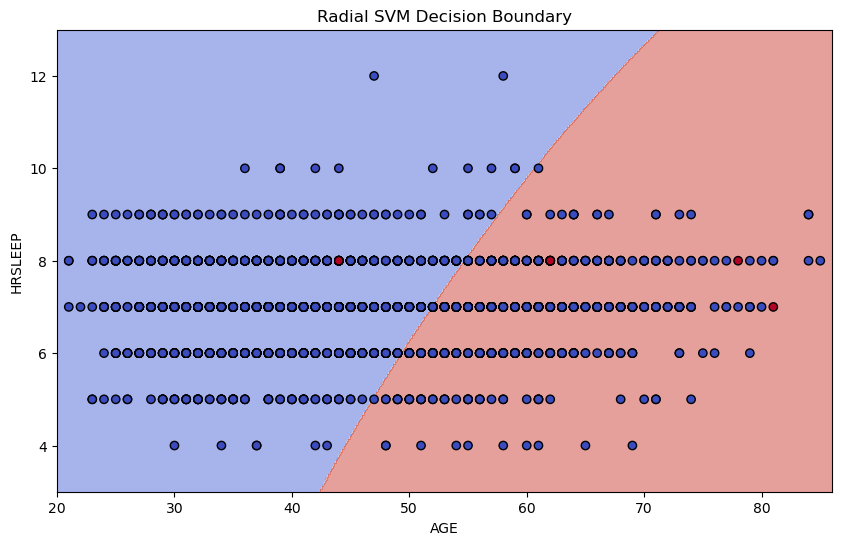

In [33]:
svm_rbf_fixed = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma=0.01, class_weight='balanced', random_state=42)
)

svm_rbf_fixed.fit(X_train, y_train)



feature1 = 'AGE'
feature2 = 'HRSLEEP'
X_train_2d = X_train[[feature1, feature2]]

svm_rbf_fixed_2d = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma=0.01, class_weight='balanced', random_state=42)
)

svm_rbf_fixed_2d.fit(X_train_2d, y_train)

x_min, x_max = X_train_2d[feature1].min() - 1, X_train_2d[feature1].max() + 1
y_min, y_max = X_train_2d[feature2].min() - 1, X_train_2d[feature2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = svm_rbf_fixed_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[feature1], X_train_2d[feature2], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Radial SVM Decision Boundary' )
plt.show()